# Yorzoi Demo

## Quick Start: Make predictions
In this demo, we make predictions for 5 random sequences each of lenght 4992 which is the sequence length Yorzoi can process.

In [5]:
import random
import torch
from yorzoi.dataset import GenomicDataset
from yorzoi.model.borzoi import Borzoi
from yorzoi.utils import untransform_then_unbin

model = Borzoi.from_pretrained("tom-ellis-lab/yorzoi")
model.to("cuda:0")
model.eval()

def random_dna_sequence(length):
    return ''.join(random.choices('ACGT', k=length))

sequences = torch.stack([torch.tensor(GenomicDataset.one_hot_encode((random_dna_sequence(4992))), dtype=torch.float32) for _ in range(5)])

print(f"\nPredicting RNA-seq coverage for {sequences.shape[0]} sequences\n")

sequences = sequences.to("cuda:0")

with torch.autocast(device_type="cuda"):
    predictions_squashed_scale = model(sequences)
    # We remove the binning and squashing transformation to get predictions at 1bp resolution in the original scale.
    predictions = untransform_then_unbin(predictions_squashed_scale, resolution=10)

print(f"Made predictions for {predictions.shape[0]} sequences, {predictions.shape[1]} tracks each (sense: {predictions.shape[1]//2}, antisense: {predictions.shape[1]//2}), \nacross {predictions.shape[2]} bins (resolution=10 => 3000 bp). The first half of the tracks are \nthe sense strand, the second half are the antisense strand. The first track \nof the first half belongs to the same RNA-seq experiment as the first track \nof the second half and so on.\n")

resolution: 10

Predicting RNA-seq coverage for 5 sequences

Made predictions for 5 sequences, 162 tracks each (sense: 81, antisense: 81), 
across 3000 bins (resolution=10 => 3000 bp). The first half of the tracks are 
the sense strand, the second half are the antisense strand. The first track 
of the first half belongs to the same RNA-seq experiment as the first track 
of the second half and so on.



/home/tds122/test-yorzoi/.venv/lib64/python3.9/site-packages/yorzoi/model/borzoi.py:364: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


## Visualising Predictions

Here, we visualise Yorzoi predictions per track for the first sample.

In [ ]:
import json

predictions_sequence_0 = predictions[0, :, :]

# Load track names from annotation file 
with open("track_annotation.json", "r") as f:
    track_names = json.load(f)

idx2name = track_names['+'] + track_names['-']

### Example Illumina track prediction (Sample 0)
Tracks from index 0 to index 9 represent 5' to 3' normalized read coverage from Illumina RNA-seq experiments that we conducted on 10 strains, each carrying a human DNA insert. Tracks 81 to 89 represent the matching 3' to 5' tracks for the same experiments. 

Here we show the predicted coverage for a random sequence (from step before) on two tracks: 5' to 3' (blue) and 3' to 5' (red) from the same experiment.

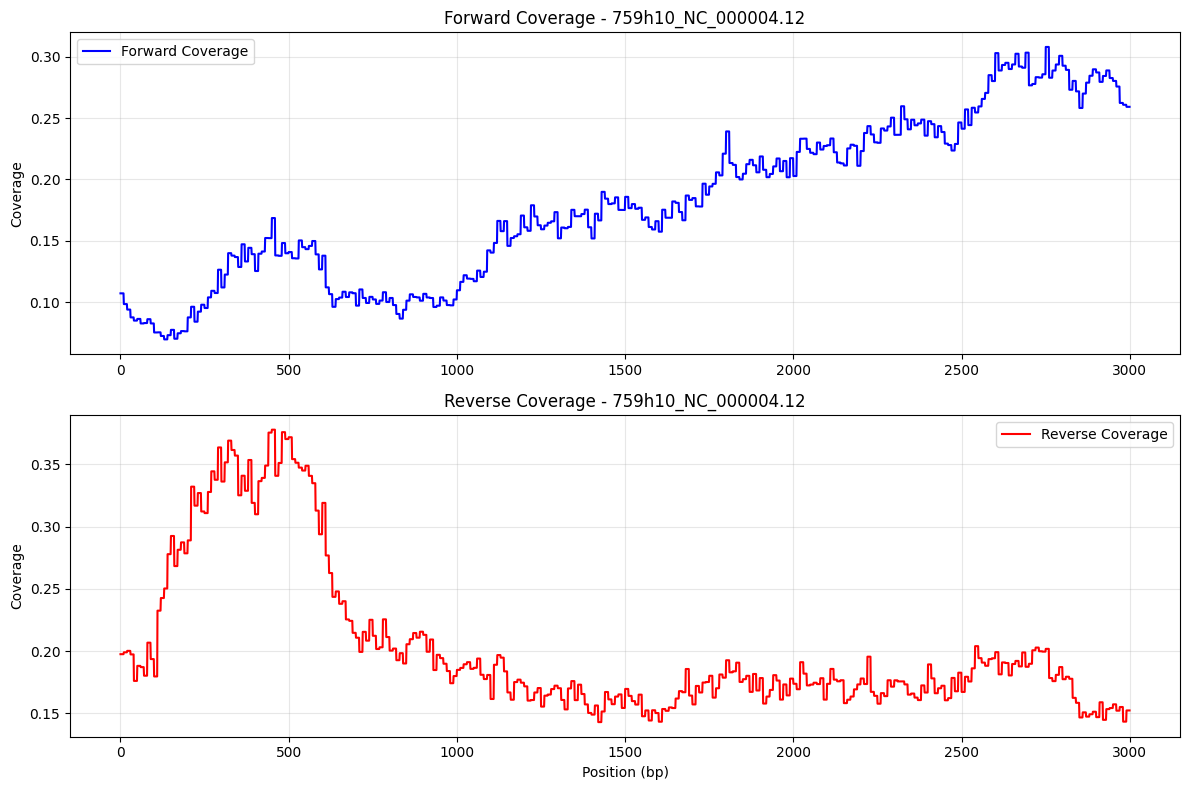

In [17]:
fwd_idx = 0
rev_idx = fwd_idx + 81

fwd_coverage_value = predictions_sequence_0[fwd_idx, :]
rev_coverage_value = predictions_sequence_0[rev_idx, :]

# Plot forward and reverse coverage values
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot forward coverage
ax1.plot(fwd_coverage_value.detach().cpu().numpy(), label='Forward Coverage', color='blue')
ax1.set_title(f'Forward Coverage - {idx2name[fwd_idx]}')
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot reverse coverage
ax2.plot(rev_coverage_value.detach().cpu().numpy(), label='Reverse Coverage', color='red')
ax2.set_title(f'Reverse Coverage - {idx2name[rev_idx]}')
ax2.set_xlabel('Position (bp)')
ax2.set_ylabel('Coverage')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Sample 0, Nanopore track prediction

Tracks with index 11 to 80 and 92 to 192 are Nanopore tracks from Brooks et al. (2022) (see track_annotation.json). JSXXX are the respective strain names from their SCRAMBLE experiments.

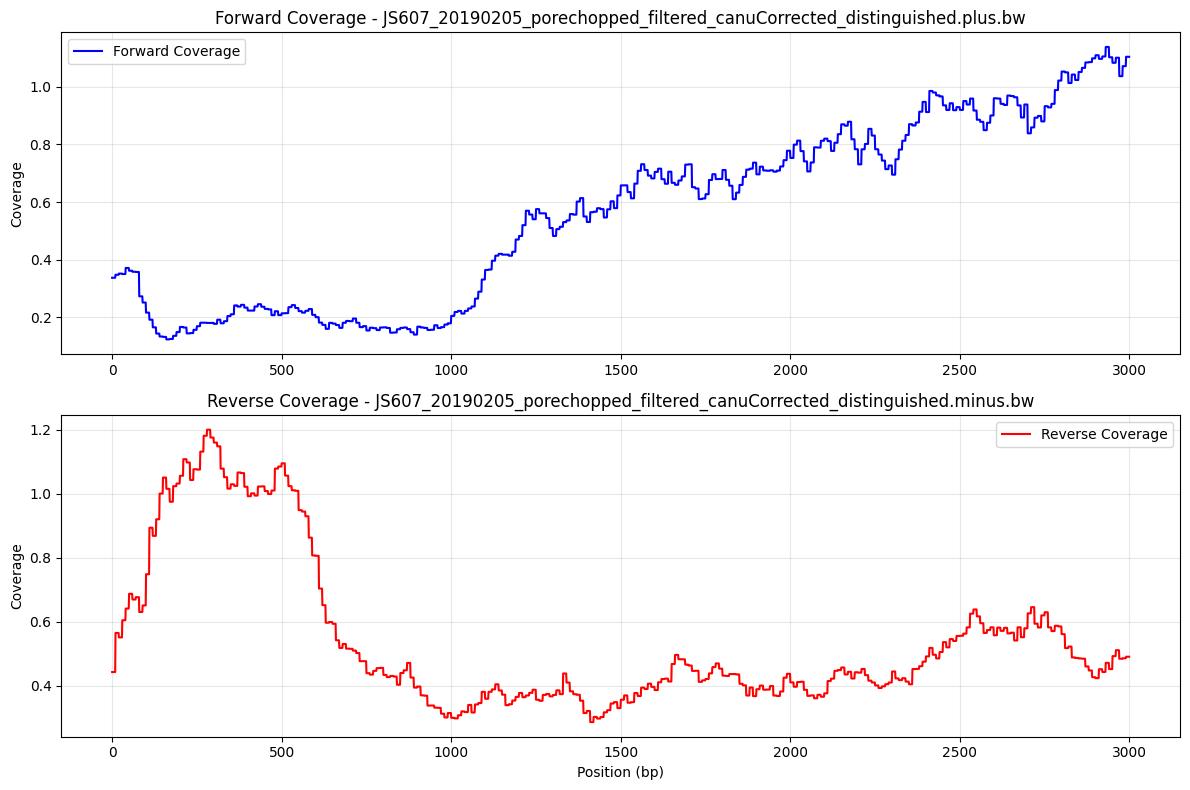

In [ ]:
fwd_idx = 20
rev_idx = fwd_idx + 81

fwd_coverage_value = predictions_sequence_0[fwd_idx, :]
rev_coverage_value = predictions_sequence_0[rev_idx, :]

# Plot forward and reverse coverage values
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot forward coverage
ax1.plot(fwd_coverage_value.detach().cpu().numpy(), label='Forward Coverage', color='blue')
ax1.set_title(f'Forward Coverage - {idx2name[fwd_idx]}')
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot reverse coverage
ax2.plot(rev_coverage_value.detach().cpu().numpy(), label='Reverse Coverage', color='red')
ax2.set_title(f'Reverse Coverage - {idx2name[rev_idx]}')
ax2.set_xlabel('Position (bp)')
ax2.set_ylabel('Coverage')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
